# Section 3

In this section of tutorial, you will:
1. Load an unlabeled base dataset and an unlabeled target dataset
2. Access to some labels in the base dataset
3. Derive the calibration curve and class-conditional density function for base dataset
4. Extrapolate those two properties from base dataset to the target dataset, using PE and Mixture Model.

For the exercises, we ask you to rerun this code on a different dataset and answer the following questions:
1. Fill in columns H-K for datasets 1-4
2. Which sampling methods yield the smallest confidence intervals?
3. For which datasets does the choice of PE vs. MM make the most difference? Call this the uncertainty due to the stability assumption?
4. How does the uncertainty due to the choice of stability assumption compare to the uncertainty due to sample size and choice of sampling method

You should also fill in column H and K for dataset 1-4 in your copy of the [results spreadsheet]( https://docs.google.com/spreadsheets/d/10oEQR-_6px9sRF3cRiIPChiBcrWPVPy12TN7oHCA4qU), based on your findings from the notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from util import plot_stacked_frequency
from util import DataHandler
from util import NPBinningCalibrationCurve, LogisticCalibrationCurve, ProbabilityEstimator, MixtureModelEstimator

## 1. Load a base dataset and a target dataset

In [2]:
# base is a very large dataset
base_dh = DataHandler('data/dataset1_base.csv')
target_dh = DataHandler('data/dataset1_target.csv')

In [3]:
# TODO: change the datasets
# base_dh = DataHandler('data/dataset2_target.csv')
# target_dh = DataHandler('data/dataset2_target.csv')

In [4]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,C(X),GT
0,0.254796,
1,0.888630,
2,0.815468,
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


## 2. distribution of classifier scores

Target is very different from base!

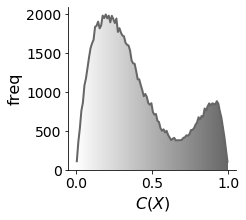

In [5]:
base_dh.plot_dist_classifier_scores()

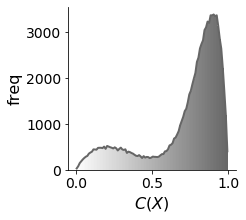

In [6]:
target_dh.plot_dist_classifier_scores()

## 3. Assume Stable calibration curve

### Repeat the code blocks below
=======================

Specify different sampling and n_item

### 3.1 Calibration phase: get a sample for annotation from base dataset

In [7]:
# remember to reset all oracle labels before each run
base_dh.hide_all_oracle()

In [8]:
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='random')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='uniform on C(X)')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [9]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [10]:
base_dh.count_gt()

5000

In [11]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
13215,0.677874,False
13221,0.617350,True
13228,0.663543,False
13246,0.653422,False


In [12]:
sample_df = base_dh.sample_df

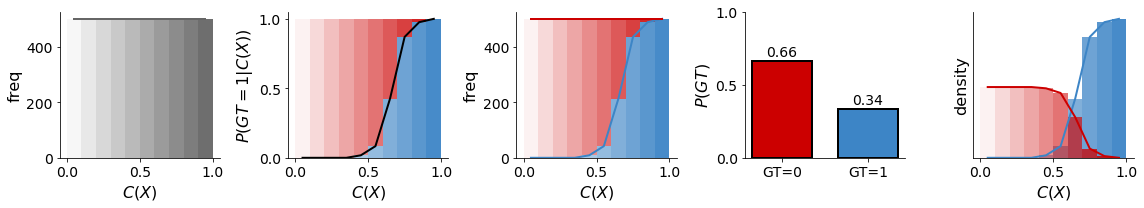

In [13]:
base_dh.generate_all_distribution_plots(df=sample_df, num_bin=10)

### 3.2 Get a calibration curve by Platt scaling

In [14]:
sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(sample_df)

### 3.3 Extrapolate the calibration curve to the target period

In [15]:
pe_estimator = ProbabilityEstimator()

pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = target_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.7015559586381045

### 3.4 Add bootstrap sampling for confidence interval

In [16]:
def extrinsic_bootstrap_estimating(input_cx_array, df, num_bootstrap, calibration_curve='platt scaling', verbose=False):
    # sample with replacement on the 5000 labeled df

    pe_estimator = ProbabilityEstimator()

    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(df)
        bootstrapped_sample_df = df.sample(frac=1, replace=True)

        if calibration_curve == 'platt scaling':
            bootstrapped_calibration_curve = LogisticCalibrationCurve()
            bootstrapped_calibration_curve.fit(bootstrapped_sample_df)
        elif calibration_curve == 'nonparametric binning':
            bootstrapped_calibration_curve = NPBinningCalibrationCurve(bootstrapped_sample_df, num_bin=10)

        pe_estimator.set_calibration_curve(bootstrapped_calibration_curve)

        bootstrapped_pe_estimation = pe_estimator.estimate(input_cx_array)
        if verbose:
            print(f'bootstrap {bootstrap_idx+1:>3}: {bootstrapped_pe_estimation:.4f}')
        estimated_result_list.append(bootstrapped_pe_estimation)    
    return estimated_result_list

In [17]:
def get_median_CI(lst):
    return np.median(lst), np.percentile(lst, 2.5), np.percentile(lst, 97.5)

In [18]:
ps_estimated_result_list = extrinsic_bootstrap_estimating(target_dh.observed_df['C(X)'].values, 
                                                          sample_df, 
                                                          num_bootstrap=1000, 
                                                          calibration_curve='platt scaling', 
                                                          verbose=True)

bootstrap   1: 0.6939
bootstrap   2: 0.6979
bootstrap   3: 0.7040
bootstrap   4: 0.7043
bootstrap   5: 0.7041
bootstrap   6: 0.7063
bootstrap   7: 0.7015
bootstrap   8: 0.7032
bootstrap   9: 0.7017
bootstrap  10: 0.7021
bootstrap  11: 0.6960
bootstrap  12: 0.6970
bootstrap  13: 0.7014
bootstrap  14: 0.7040
bootstrap  15: 0.7043
bootstrap  16: 0.7054
bootstrap  17: 0.7042
bootstrap  18: 0.7030
bootstrap  19: 0.7000
bootstrap  20: 0.7006
bootstrap  21: 0.7007
bootstrap  22: 0.7005
bootstrap  23: 0.6946
bootstrap  24: 0.7012
bootstrap  25: 0.7032
bootstrap  26: 0.7054
bootstrap  27: 0.6985
bootstrap  28: 0.7016
bootstrap  29: 0.7102
bootstrap  30: 0.6987
bootstrap  31: 0.6999
bootstrap  32: 0.7049
bootstrap  33: 0.7013
bootstrap  34: 0.7025
bootstrap  35: 0.6974
bootstrap  36: 0.7038
bootstrap  37: 0.6961
bootstrap  38: 0.7070
bootstrap  39: 0.7017
bootstrap  40: 0.7047
bootstrap  41: 0.6988
bootstrap  42: 0.6999
bootstrap  43: 0.6993
bootstrap  44: 0.7000
bootstrap  45: 0.6917
bootstrap 

bootstrap 379: 0.6928
bootstrap 380: 0.7011
bootstrap 381: 0.7016
bootstrap 382: 0.7087
bootstrap 383: 0.7020
bootstrap 384: 0.7005
bootstrap 385: 0.7029
bootstrap 386: 0.7048
bootstrap 387: 0.7045
bootstrap 388: 0.7025
bootstrap 389: 0.7021
bootstrap 390: 0.6973
bootstrap 391: 0.6957
bootstrap 392: 0.7035
bootstrap 393: 0.6993
bootstrap 394: 0.7078
bootstrap 395: 0.6970
bootstrap 396: 0.7055
bootstrap 397: 0.6978
bootstrap 398: 0.7033
bootstrap 399: 0.7009
bootstrap 400: 0.6988
bootstrap 401: 0.6935
bootstrap 402: 0.7015
bootstrap 403: 0.7027
bootstrap 404: 0.7008
bootstrap 405: 0.7025
bootstrap 406: 0.7040
bootstrap 407: 0.7013
bootstrap 408: 0.7058
bootstrap 409: 0.6999
bootstrap 410: 0.6996
bootstrap 411: 0.7015
bootstrap 412: 0.7032
bootstrap 413: 0.7036
bootstrap 414: 0.6996
bootstrap 415: 0.7026
bootstrap 416: 0.6969
bootstrap 417: 0.6998
bootstrap 418: 0.6989
bootstrap 419: 0.7011
bootstrap 420: 0.7004
bootstrap 421: 0.6965
bootstrap 422: 0.7066
bootstrap 423: 0.6998
bootstrap 

bootstrap 770: 0.7000
bootstrap 771: 0.7023
bootstrap 772: 0.7014
bootstrap 773: 0.7056
bootstrap 774: 0.7023
bootstrap 775: 0.7004
bootstrap 776: 0.7045
bootstrap 777: 0.6993
bootstrap 778: 0.7007
bootstrap 779: 0.6982
bootstrap 780: 0.6971
bootstrap 781: 0.7087
bootstrap 782: 0.7024
bootstrap 783: 0.6972
bootstrap 784: 0.6995
bootstrap 785: 0.7036
bootstrap 786: 0.7037
bootstrap 787: 0.6977
bootstrap 788: 0.7037
bootstrap 789: 0.6998
bootstrap 790: 0.7030
bootstrap 791: 0.7061
bootstrap 792: 0.7032
bootstrap 793: 0.7012
bootstrap 794: 0.7050
bootstrap 795: 0.7048
bootstrap 796: 0.6983
bootstrap 797: 0.7011
bootstrap 798: 0.7045
bootstrap 799: 0.6989
bootstrap 800: 0.6989
bootstrap 801: 0.6976
bootstrap 802: 0.7057
bootstrap 803: 0.6984
bootstrap 804: 0.6992
bootstrap 805: 0.7021
bootstrap 806: 0.6990
bootstrap 807: 0.7038
bootstrap 808: 0.7026
bootstrap 809: 0.7003
bootstrap 810: 0.7108
bootstrap 811: 0.7015
bootstrap 812: 0.7063
bootstrap 813: 0.6962
bootstrap 814: 0.6998
bootstrap 

In [19]:
get_median_CI(ps_estimated_result_list)

(0.7016042370566196, 0.6944243379108136, 0.7085431175663269)

In [20]:
target_dh._p_gt

0.8

=====================
### Repeat the code blocks above

## 4. Assume Stable class-conditional densities

### Repeat the code blocks below
=======================

Specify different sampling and n_item

## 4.1 Calibration phase: get a sample for annotation from base dataset

In [21]:
# remember to reset all oracle labels before each run
base_dh.hide_all_oracle()

In [22]:
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='random')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='uniform on C(X)')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [23]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [24]:
base_dh.count_gt()

5000

In [25]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
13215,0.677874,False
13221,0.617350,True
13228,0.663543,False
13246,0.653422,False


In [26]:
sample_df = base_dh.sample_df

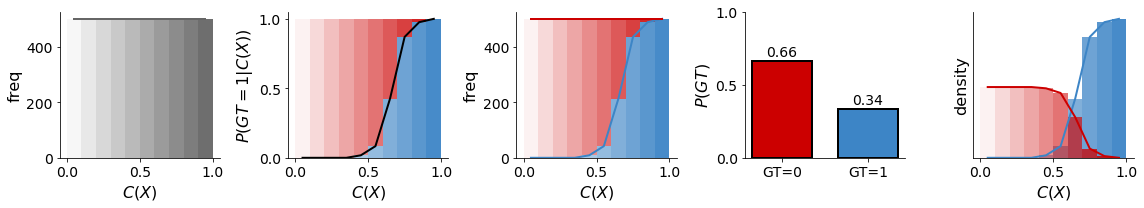

In [27]:
base_dh.generate_all_distribution_plots(df=sample_df, num_bin=10)

### 4.2 Get a calibration curve by Platt scaling

In [28]:
sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(sample_df)

### 4.3 Derive the class-conditional density functions in base dataset. We cannot use the class-conditional density function of sample_df directly, we have to recover the  class-conditional density function for base by inverse-weighting

In [29]:
sample_df = base_dh.sample_df
x_axis = np.linspace(0, 1, 11)

base_cx_hist, _ = np.histogram(base_dh.observed_df['C(X)'].values, bins=x_axis, density=True)
sample_cx_hist, _ = np.histogram(sample_df['C(X)'].values, bins=x_axis, density=True)

weight = base_cx_hist / sample_cx_hist

pos_cx = sample_df[sample_df['GT'] == True]['C(X)'].values
neg_cx = sample_df[sample_df['GT'] == False]['C(X)'].values

pos_hist_freq, _ = np.histogram(pos_cx, bins=x_axis, density=True)
neg_hist_freq, _ = np.histogram(neg_cx, bins=x_axis, density=True)

pos_hist_freq *= weight
pos_total = np.sum(pos_hist_freq)
pos_hist_freq /= pos_total

neg_hist_freq *= weight
neg_total = np.sum(neg_hist_freq)
neg_hist_freq /= neg_total

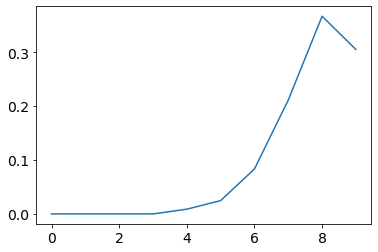

In [30]:
plt.plot(np.arange(10), pos_hist_freq)

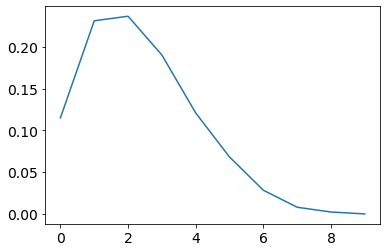

In [31]:
plt.plot(np.arange(10), neg_hist_freq)

In [32]:
mixture_model_estimator = MixtureModelEstimator()
mixture_model_estimator.fit(base_dh.sample_df, base_dh.observed_df['C(X)'].values, num_bin=10)

### 4.3 Extrapolate the calibration curve to the target period

In [33]:
mixture_model_estimator.estimate(target_dh.observed_df['C(X)'].values)

0.8

### 4.4 Add bootstrap sampling for confidence interval

In [34]:
def intrinsic_bootstrap_estimating(target_cx, sample_df, base_cx, num_bootstrap, verbose=False):
    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(sample_df)
        bootstrapped_sample_df = sample_df.sample(frac=1, replace=True)
                    
        mixture_model_estimator = MixtureModelEstimator()
        mixture_model_estimator.fit(bootstrapped_sample_df, base_dh.observed_df['C(X)'].values, num_bin=10)
        
        bootstrapped_mm_estimation = mixture_model_estimator.estimate(target_cx)
        
        if verbose:
            print(f'bootstrap {bootstrap_idx+1:>3}: {bootstrapped_mm_estimation:.4f}')
        estimated_result_list.append(bootstrapped_mm_estimation)    
    return estimated_result_list

In [35]:
def get_median_CI(lst):
    return np.median(lst), np.percentile(lst, 2.5), np.percentile(lst, 97.5)

In [36]:
mm_estimated_result_list = intrinsic_bootstrap_estimating(target_dh.observed_df['C(X)'].values, 
                                                          sample_df=sample_df, 
                                                          base_cx=base_dh.observed_df['C(X)'].values,
                                                          num_bootstrap=1000, 
                                                          verbose=True)

bootstrap   1: 0.8000
bootstrap   2: 0.8000
bootstrap   3: 0.8100
bootstrap   4: 0.8000
bootstrap   5: 0.8000
bootstrap   6: 0.8000
bootstrap   7: 0.8000
bootstrap   8: 0.8000
bootstrap   9: 0.8000
bootstrap  10: 0.8000
bootstrap  11: 0.8000
bootstrap  12: 0.8100
bootstrap  13: 0.8100
bootstrap  14: 0.8000
bootstrap  15: 0.8100
bootstrap  16: 0.8000
bootstrap  17: 0.8000
bootstrap  18: 0.8000
bootstrap  19: 0.8100
bootstrap  20: 0.8000
bootstrap  21: 0.8100
bootstrap  22: 0.8100
bootstrap  23: 0.8000
bootstrap  24: 0.8000
bootstrap  25: 0.8000
bootstrap  26: 0.8000
bootstrap  27: 0.8000
bootstrap  28: 0.8000
bootstrap  29: 0.8000
bootstrap  30: 0.8000
bootstrap  31: 0.8000
bootstrap  32: 0.8100
bootstrap  33: 0.8100
bootstrap  34: 0.8100
bootstrap  35: 0.8100
bootstrap  36: 0.8000
bootstrap  37: 0.8100
bootstrap  38: 0.8100
bootstrap  39: 0.8100
bootstrap  40: 0.8000
bootstrap  41: 0.8000
bootstrap  42: 0.8000
bootstrap  43: 0.8000
bootstrap  44: 0.8000
bootstrap  45: 0.8000
bootstrap 

bootstrap 377: 0.8100
bootstrap 378: 0.8000
bootstrap 379: 0.8000
bootstrap 380: 0.8000
bootstrap 381: 0.8000
bootstrap 382: 0.8000
bootstrap 383: 0.8000
bootstrap 384: 0.8000
bootstrap 385: 0.8000
bootstrap 386: 0.8000
bootstrap 387: 0.8000
bootstrap 388: 0.8100
bootstrap 389: 0.8000
bootstrap 390: 0.8000
bootstrap 391: 0.8000
bootstrap 392: 0.8100
bootstrap 393: 0.8000
bootstrap 394: 0.8000
bootstrap 395: 0.8000
bootstrap 396: 0.8000
bootstrap 397: 0.8000
bootstrap 398: 0.8100
bootstrap 399: 0.8000
bootstrap 400: 0.8000
bootstrap 401: 0.8000
bootstrap 402: 0.8000
bootstrap 403: 0.8000
bootstrap 404: 0.8000
bootstrap 405: 0.8000
bootstrap 406: 0.8100
bootstrap 407: 0.8100
bootstrap 408: 0.8000
bootstrap 409: 0.8000
bootstrap 410: 0.8000
bootstrap 411: 0.8100
bootstrap 412: 0.8100
bootstrap 413: 0.8000
bootstrap 414: 0.8000
bootstrap 415: 0.8100
bootstrap 416: 0.8000
bootstrap 417: 0.8000
bootstrap 418: 0.8000
bootstrap 419: 0.8000
bootstrap 420: 0.8000
bootstrap 421: 0.8000
bootstrap 

bootstrap 751: 0.8000
bootstrap 752: 0.8000
bootstrap 753: 0.8000
bootstrap 754: 0.8000
bootstrap 755: 0.8100
bootstrap 756: 0.8000
bootstrap 757: 0.8000
bootstrap 758: 0.8000
bootstrap 759: 0.8000
bootstrap 760: 0.8000
bootstrap 761: 0.8000
bootstrap 762: 0.8000
bootstrap 763: 0.8100
bootstrap 764: 0.8000
bootstrap 765: 0.8000
bootstrap 766: 0.8000
bootstrap 767: 0.8000
bootstrap 768: 0.8100
bootstrap 769: 0.8000
bootstrap 770: 0.8000
bootstrap 771: 0.8000
bootstrap 772: 0.8000
bootstrap 773: 0.8000
bootstrap 774: 0.8100
bootstrap 775: 0.8000
bootstrap 776: 0.8000
bootstrap 777: 0.8000
bootstrap 778: 0.8100
bootstrap 779: 0.8000
bootstrap 780: 0.8000
bootstrap 781: 0.8000
bootstrap 782: 0.8000
bootstrap 783: 0.8000
bootstrap 784: 0.8000
bootstrap 785: 0.8100
bootstrap 786: 0.8000
bootstrap 787: 0.8100
bootstrap 788: 0.8000
bootstrap 789: 0.8000
bootstrap 790: 0.8000
bootstrap 791: 0.8100
bootstrap 792: 0.8000
bootstrap 793: 0.8000
bootstrap 794: 0.8000
bootstrap 795: 0.8000
bootstrap 

In [37]:
get_median_CI(mm_estimated_result_list)

(0.8, 0.8, 0.81)

In [38]:
target_dh._p_gt

0.8

=====================
## Repeat the code blocks above